# Kmeans clustering with kmeans++ initialization

Reference [ClusteringAnalysis.jl](https://github.com/AugustoCL/ClusterAnalysis.jl) 

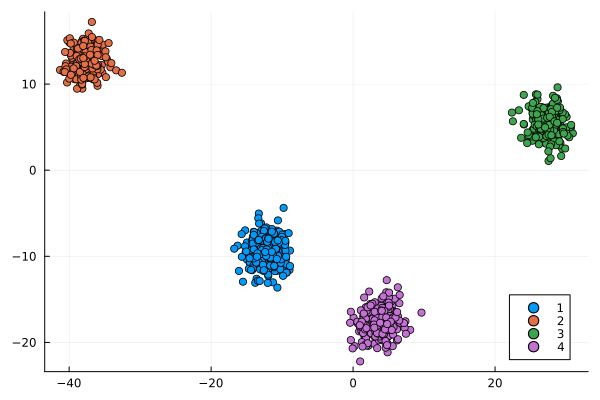

In [38]:
using Plots, CluGen, BenchmarkTools, LinearAlgebra

o = clugen(2, 4, 1000, [1, 0], pi / 8, [20, 10], 10, 1, 1.5)
p = plot(o.points[:, 1], o.points[:, 2], seriestype = :scatter, group=o.clusters)

In [39]:
data = collect(o.points')

2×1000 Matrix{Float64}:
 -11.7984   -12.3658    -9.93226  -11.8415  …    3.81536    2.9956    4.81019
  -9.68341   -9.70773  -11.1665   -10.4845     -17.7127   -18.286   -17.8684

In [40]:
function euclidean(a::AbstractVector{T}, 
                   b::AbstractVector{T}) where {T<:AbstractFloat}
    @assert length(a) == length(b)

    # euclidean(a, b) = √∑(aᵢ- bᵢ)²
    s = zero(T)
    @simd for i in eachindex(a)
        @inbounds s += (a[i] - b[i])^2
    end
    return √s
end

euclidean (generic function with 1 method)

In [41]:
function squared_error(data::AbstractMatrix{T}) where {T<:AbstractFloat}
    error = zero(T)
    @simd for i in axes(data, 2)
        error += squared_error(view(data, :, i))
    end
    return error
end

function squared_error(col::AbstractVector{T}) where {T<:AbstractFloat}
    μ = mean(col)
    error = zero(T)
    @simd for i in eachindex(col)
        @inbounds error += (col[i] - μ)^2
    end
    return error
end

squared_error (generic function with 2 methods)

In [42]:
function _initialize_centroids(data::AbstractMatrix{T}, K::Int) where {T<:AbstractFloat}
    nl = size(data, 1)

    centroids = Vector{Vector{T}}(undef, K)
    centroids[1] = data[rand(1:nl), :]

    # distance vector for each observation
    dists = Vector{T}(undef, nl)

    # get each new centroid by the furthest observation (maximum distance)
    for k in 2:K

        # for each observation get the nearest centroid by the minimum distance
        for (i, row) in enumerate(eachrow(data))
            dist_c = [euclidean(row, c) for c in @view centroids[1:(k-1)]]
            @inbounds dists[i] = minimum(dist_c)
        end

        # new centroid by the furthest observation
        @inbounds centroids[k] = data[argmax(dists), :]
    end
    return centroids
end

_initialize_centroids (generic function with 2 methods)

In [43]:
function totalwithinss(data::AbstractMatrix{T}, K::Int, cluster::AbstractVector{Int}) where {T<:AbstractFloat}
    # evaluate total-variance-within-clusters
    error = zero(T)
    for k in 1:K
        error += squared_error(data[cluster .== k, :])
    end
    return error
end

totalwithinss (generic function with 1 method)

In [44]:
function _kmeans(data::AbstractMatrix, K::Int, maxiter::Int) 

    nl = size(data, 1)

    # generate random centroids
    centroids = _initialize_centroids(data, K)

    # first clusters estimate
    cluster = Vector{Int}(undef, nl)
    for (i, obs) in enumerate(eachrow(data))
        dist = [euclidean(obs, c) for c in centroids]
        @inbounds cluster[i] = argmin(dist)
    end

    # first evaluation of total-variance-within-cluster
    withinss = totalwithinss(data, K, cluster)

    # variables to update during the iterations
    new_centroids = copy(centroids)
    new_cluster = copy(cluster)
    iter = 1
    norms = norm.(centroids)

    # start kmeans iterations until maxiter or convergence
    for _ in 2:maxiter

        # update new_centroids using the mean
        @simd for k in 1:K             # mean.(eachcol(data[new_cluster .== k, :]))
            @inbounds new_centroids[k] = vec(mean(view(data, new_cluster .== k, :), dims = 1))
        end

        # estimate cluster to all observations
        for (i, obs) in enumerate(eachrow(data))
            dist = [euclidean(obs, c) for c in new_centroids]
            @inbounds new_cluster[i] = argmin(dist)
        end

        # update iter, withinss-variance and calculate centroid norms
        new_withinss = totalwithinss(data, K, new_cluster)
        new_norms = norm.(new_centroids)
        iter += 1

        # convergence rule
        norm(norms - new_norms) ≈ 0 && break

        # update centroid norms
        norms .= new_norms

        # update centroids, cluster and whithinss
        if new_withinss < withinss
            centroids .= new_centroids
            cluster .= new_cluster
            withinss = new_withinss
        end

    end

    return centroids, cluster, withinss, iter
end

_kmeans (generic function with 1 method)

In [45]:
function kmeans(data::AbstractMatrix{T}, K::Int;
                nstart::Int = 1,
                maxiter::Int = 10) where {T<:AbstractFloat}
    

    nl = size(data, 1)

    centroids = Vector{Vector{T}}(undef, K)
    cluster = Vector{Int}(undef, nl)
    withinss = Inf
    iter = 0

    # run multiple kmeans to get the best result
    for _ in 1:nstart

        new_centroids, new_cluster, new_withinss, new_iter = _kmeans(data, K, maxiter)

        if new_withinss < withinss
            centroids .= new_centroids
            cluster .= new_cluster
            withinss = new_withinss
            iter = new_iter
        end
    end

    return centroids, cluster, withinss
end

kmeans (generic function with 1 method)

In [48]:
centroids, cluster, withinss = kmeans(data, 4)

([[-11.79838966933231, -12.365792238168897, -9.932258366051519, -11.8415377015064, -11.898731259726269, -10.69783599276371, -12.867252119797724, -14.573764477791745, -11.800591208512293, -13.90632900698694  …  4.03648889243854, 1.3326752817645537, 0.9368430395051384, 2.0360720393528657, 2.467776707000948, 5.446551684073461, 0.9992440748015949, 3.8153642240613674, 2.9956036682839766, 4.81019137308159], [-9.683410247017635, -9.70772502120277, -11.166517802190317, -10.484474891274896, -8.666242795679393, -10.232152541077523, -8.475152636294649, -10.122960004391455, -9.061681562230802, -7.648783900598339  …  -16.325576881655962, -20.482844194830086, -18.00191665259015, -15.922719492453098, -15.704221255197067, -18.559221025429, -22.206521088956066, -17.712657053788863, -18.28599755645821, -17.868386723850513], [-11.79838966933231, -12.365792238168897, -9.932258366051519, -11.8415377015064, -11.898731259726269, -10.69783599276371, -12.867252119797724, -14.573764477791745, -11.80059120851229